In [2]:
%matplotlib inline
from SALib.sample import saltelli
from batchrunner import BatchRunnerMP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from model import BeeEvolutionModel
from agents import *
import pickle

## OFAT Sensitivity Analysis(Local Analysis)

In [24]:
"""
Producing the data for the OFAT sensitivity analysis, then save the data in ./results/ofat_output.npz
"""


problem = {
    'num_vars': 4,
    'names': ['alpha', 'forager_royal_ratio', 'growth_factor', 'resource_variability'],
    'bounds': [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0, 0.5]],
    'nominal_value': [0.5, 0.5, 0.5, 0.25]
}

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 2
distinct_samples = 2
seed = 20

# Set the outputs
model_reporters = {"Total Workers": lambda m: len([agent for agent in m.schedule_bees_and_flower_patches.agents if isinstance(agent, Worker)]),
                   "Total Queens": lambda m: len([agent for agent in m.schedule_bees_and_flower_patches.agents if isinstance(agent, Queen)]),
                   "Total Drones": lambda m: len([agent for agent in m.schedule_bees_and_flower_patches.agents if isinstance(agent, Drone)]),
                   "Total Fertilized Queens": lambda m: m.get_total_fertilized_queens()}

data = {}

for i, var in enumerate(problem['names']):

    # Get the bounds for this variable and get <distinct_samples> samples within this space (uniform)
    samples = np.linspace(*problem['bounds'][i], num=distinct_samples)
    
    fixed_parameters = {}
    for j, var_ in enumerate(problem['names']):
        if j != i:
            fixed_parameters[var_] = problem['nominal_value'][j]
    fixed_parameters["seed"] = seed
    
    variable_parameters=[{var: sample} for sample in samples]
    
    batch = BatchRunnerMP(BeeEvolutionModel, 
                        fixed_parameters=fixed_parameters,
                        iterations=replicates,
                        variable_parameters=variable_parameters,
                        model_reporters=model_reporters,
                        display_progress=True)
    
    batch.run_all()
    
    data[var] = batch.get_model_vars_dataframe()
    
np.savez('./results/ofat_output.npz',data=data, problem=problem, model_reporters=list(model_reporters.keys()))
    

BatchRunner MP will use 8 processors.


4it [00:19,  4.86s/it]

BatchRunner MP will use 8 processors.



4it [01:00, 15.23s/it]

BatchRunner MP will use 8 processors.



4it [00:22,  5.70s/it]

BatchRunner MP will use 8 processors.



4it [00:24,  6.08s/it]


In [27]:
ofat_results = np.load('./results/ofat_output.npz', allow_pickle=True)

data = ofat_results['data'][()]

alpha
forager_royal_ratio
growth_factor
resource_variability


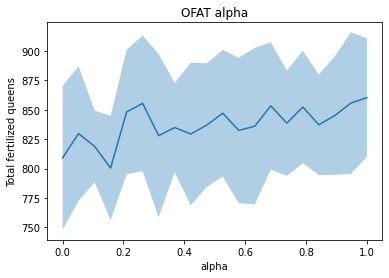

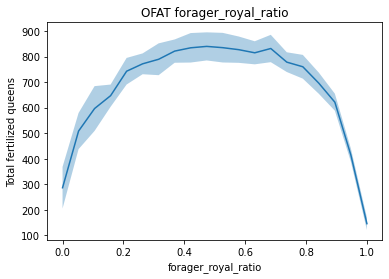

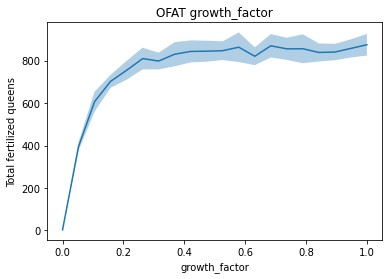

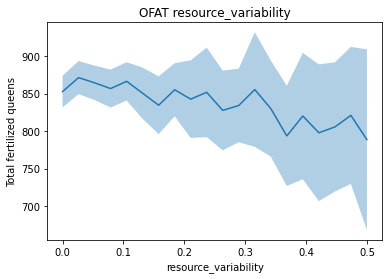

In [28]:
"""
Producing the plots from the data
"""

dict = {}
dict2 = {}
for i in data:
  dict[f'{i}'] = pd.DataFrame(data[f'{i}']).groupby(i, as_index=False)['Total Fertilized Queens']

for key, value in dict.items():
  dict2[f'{key}'] = pd.merge(value.mean().rename(columns={'Total Fertilized Queens':'Mean'}), value.std().rename(columns={'Total Fertilized Queens':'Std'}), how='right',on=key)

for key, value in  dict2.items():
  print(key)
  fig, ax = plt.subplots()
  ax.set(title=f"OFAT {key}", xlabel=f"{key}", ylabel="Total fertilized queens")
  ax.plot(dict2[f'{key}'][f'{key}'], dict2[f'{key}'].Mean)
  ax.fill_between(dict2[f'{key}'][f'{key}'], dict2[f'{key}'].Mean - dict2[f'{key}'].Std, dict2[f'{key}'].Mean + dict2[f'{key}'].Std, alpha=0.35)
  fig.savefig(f"OFAT {key}.pdf")